## 0. Introduction

The aim of this lab is to get familiar with **regression problems**, the concepts of **under/over-fitting**, and **regularization**.


1.   This lab is the first course-work activity **Assignment 1 Part 1: Regression**
2. Assignment 1 is split into 3 parts: Part 1 - Regression (Lab 3), and Part 2 - Classification (Lab 4) and Part 3 - Neural Networks (Lab 6). The three parts need to be submitted together by  **Monday, 11th November 2024, 10:00am**
3. All questions need to be completed and are assessed.
4. For each lab, a report answering the <font color = 'red'>**questions in red**</font> should be included along with the completed Notebook (.ipynb)
5. The report should be a separate file in **pdf format** (so **NOT** *doc, docx, notebook* etc.).
6. Make sure that **any figures or code** you comment on, are **included in the report**.
7. There are three parts of Assignment 1, therefore you should submit a zip file that contains 1 x Notebook and 1 x PDF for each part. In total: 3 x Notebooks and 3 x PDFs in the submission zip. Make sure the file is well identified with your name, student number, assignment number (for instance, Assignment 1), module code.
7. No other means of submission other than the appropriate QM+ link is acceptable at any time (so NO email attachments, etc.)
8. **PLAGIARISM** <ins>is an irreversible non-negotiable failure in the course</ins> (if in doubt of what constitutes plagiarism, ask!).


For this lab we will use the [diabetes](https://www4.stat.ncsu.edu/~boos/var.select/diabetes.html) dataset. Our task is to predict disease progression of diabetes, given some variables such as age, sex, body mass index, blood pressure and blood serum measurements. For more details, follow the link above.

In [ ]:
import torch
from torch import nn
from sklearn import model_selection
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn
from IPython import display
from sklearn.model_selection import train_test_split

import typing
%matplotlib inline

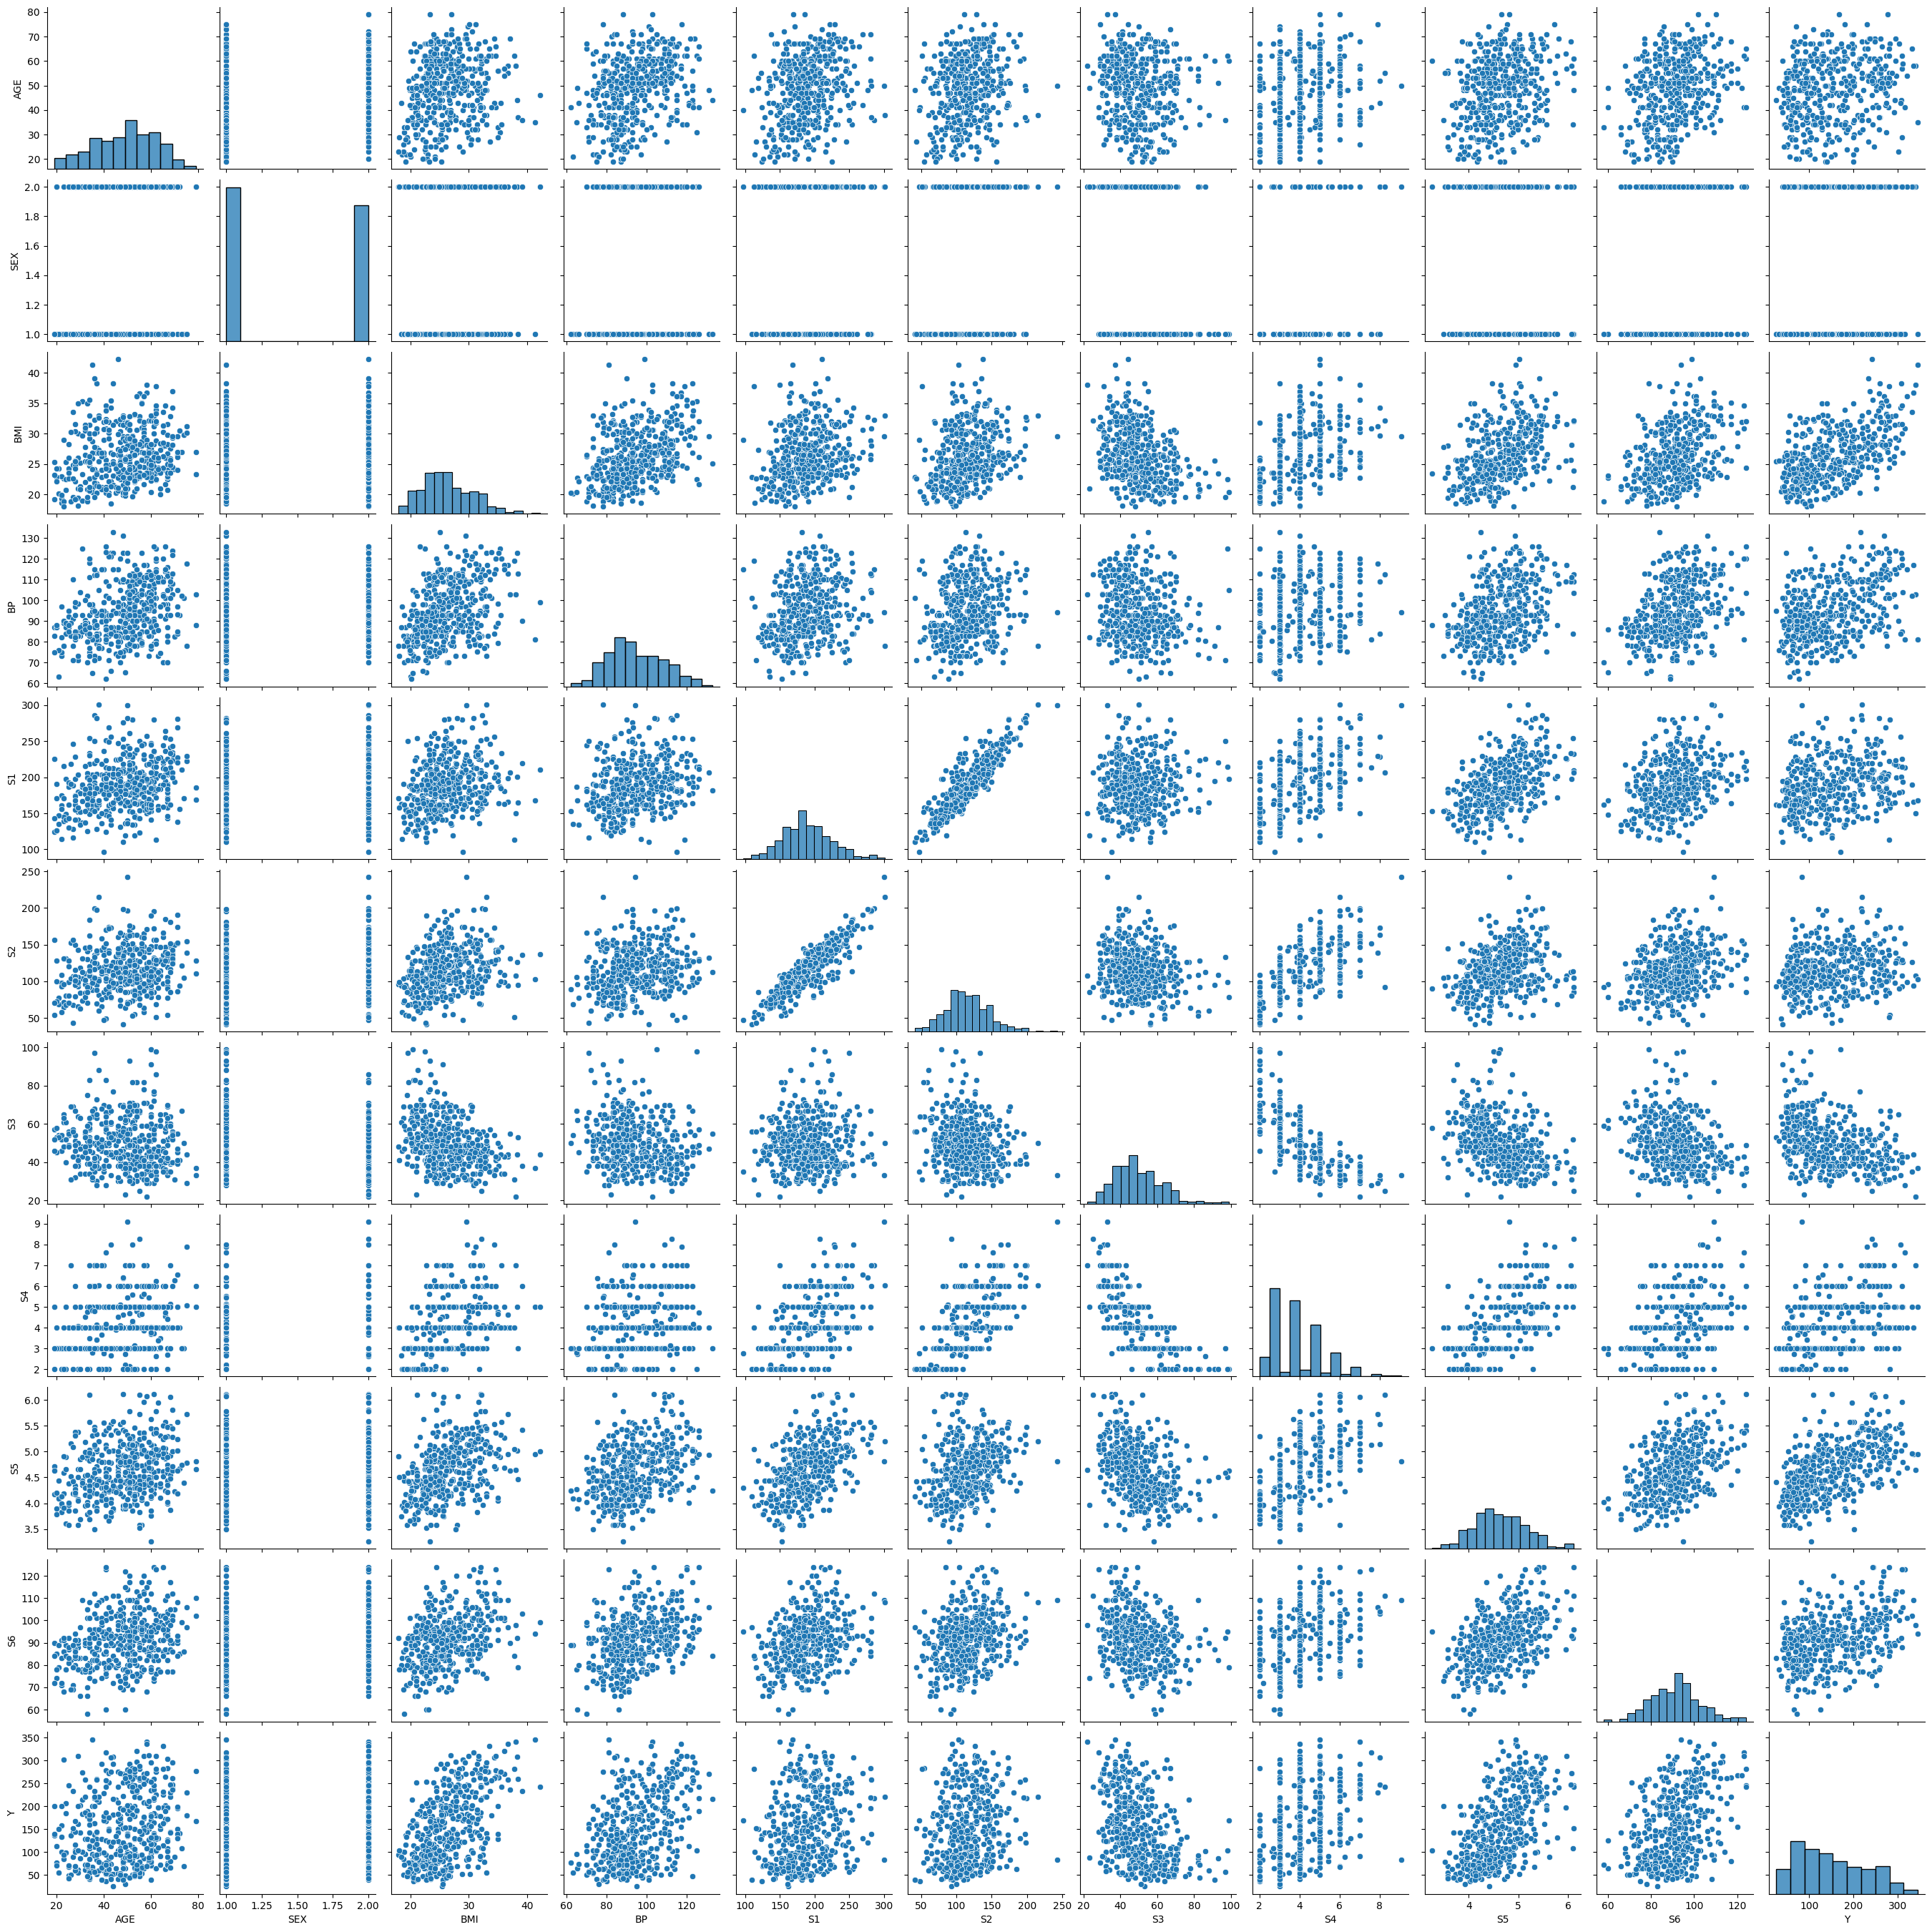

In [ ]:
diabetes_db = pd.read_csv('https://www4.stat.ncsu.edu/~boos/var.select/diabetes.tab.txt', sep='\t', header=0)
sn.pairplot(diabetes_db)

In [ ]:
diabetes_db.head(10)

,AGE,SEX,BMI,BP,S1,S2,S3,S4,S5,S6,Y
0,59,2,32.1,101.0,157,93.2,38.0,4.00,4.8598,87,151
1,48,1,21.6,87.0,183,103.2,70.0,3.00,3.8918,69,75
2,72,2,30.5,93.0,156,93.6,41.0,4.00,4.6728,85,141
3,24,1,25.3,84.0,198,131.4,40.0,5.00,4.8903,89,206
4,50,1,23.0,101.0,192,125.4,52.0,4.00,4.2905,80,135
5,23,1,22.6,89.0,139,64.8,61.0,2.00,4.1897,68,97
6,36,2,22.0,90.0,160,99.6,50.0,3.00,3.9512,82,138
7,66,2,26.2,114.0,255,185.0,56.0,4.55,4.2485,92,63
8,60,2,32.1,83.0,179,119.4,42.0,4.00,4.4773,94,110
9,29,1,30.0,85.0,180,93.4,43.0,4.00,5.3845,88,310


We first split the data into test and training sets. For consistency and to allow for meaningful comparison the same splits are maintained in the remainder of the lab.

In [ ]:
'''The training set is the portion of the data used to train the model.
During training, the model learns patterns, weights (in the case of linear regression), and other parameters by fitting the training data.
The test set is the unseen portion of the data, used solely to evaluate the model's performance after training
The purpose of the test set is to check how well the model generalizes to unseen data
'''

X_train, X_test, y_train, y_test = model_selection.train_test_split(
    diabetes_db.loc[:, diabetes_db.columns != 'Y'],
    diabetes_db['Y'],
    test_size=0.2,
    random_state=42
    )
'''
The data is converted to PyTorch Tensors to be compatible with PyTorch’s machine learning operations.
'''
x_train = torch.from_numpy(X_train.values).float()
x_test = torch.from_numpy(X_test.values).float()

y_train = torch.from_numpy(y_train.values).float()
y_train = y_train.reshape(-1, 1)

y_test = torch.from_numpy(y_test.values).float()
y_test = y_test.reshape(-1, 1)


We can see that all the independent variables are on different scales. This can affect gradient descent, we therefore need to normalize all features to zero mean, and unit standard deviation. The normalized value $z_i$ of $x_i$ is obtained through $z_i = \frac{x_i - μ}{σ}$ where $μ$ is the mean and $σ$ is the standard deviation of $X$ and $x_i, μ, σ ∈ \mathbb{R}^D$.

**Q1.** Complete the method and normalize `x_train, x_test` [2 marks]

In [ ]:
'''
features with different scales can negatively affect the performance of the gradient descent algorithm.
This ensures that all features have zero mean and unit variance,
making the optimization more efficient and preventing large feature values from dominating the gradient updates.
'''


def norm_set(x: torch.Tensor, mu: torch.Tensor, sigma: torch.Tensor) -> torch.tensor:
  ### your code here
  n_set = (x - mu) / sigma
  #print("n_set is:", n_set)
  return n_set


###your code here
mu = x_train.mean(dim=0)
sigma = x_train.std(dim=0)
x_train = norm_set(x_train, mu, sigma)
x_test = norm_set(x_test, mu, sigma)

#print("x train normalized: ", x_train)
#print("x test normalized: ",x_test)

## 1.1 Linear Regression

We will building the linear regression model in pytorch using a custom layer.

Refering back to the lecture notes, we define $ y = f(x) = w^T x$, so we need to learn weight vector $w$.

**Q2.** Fill in the forward method of the LinearRegression class. [2 marks]

In [ ]:

'''
 goal of linear regression is to model the relationship between input features X and the output target Y
 key elemets of linear regression
 Weights (w): These are the parameters the model will learn during training.In this case, they are initialized randomly,
 but they will be adjusted based on the input data to minimize the error between the predicted output and the actual output.
 Forward Method: This method defines how the model makes predictions.
 The forward method performs matrix multiplication between the input features (x) and the weight vector (w.T), which gives the predicted output y.
 '''

class LinearRegression(nn.Module):
  def __init__(self, num_features):
    super().__init__()
    self.weight = nn.Parameter(torch.ones(1, num_features), requires_grad=False) #defines a custom linear regression model using PyTorch’s nn.Module

  def forward(self, x):
    ### your code here
    y = torch.matmul(x, self.weight.T) #transpose of the vector
    return y


As we need to account for the bias, we add a column of ones to the `x_data`

In [ ]:
# add a feature for bias

x_train = torch.cat([x_train, torch.ones(x_train.shape[0], 1)], dim=1)
x_test = torch.cat([x_test, torch.ones(x_test.shape[0], 1)], dim=1)

In [ ]:
## test the custom layer
model = LinearRegression(x_train.shape[1])
prediction = model(x_train)
prediction.shape

torch.Size([353, 1])

The next step is to calculate the cost. For this we will use the mean squared error $E(w) = \frac{1}{N} Σ_{i=0}^N (f(x_i) - y_i)^2$

**Q3.** Fill in the method to calculate the squared error of for any set of labels $y$ and predictions [2 marks]

In [ ]:
'''
calculates the average squared difference between predicted and true labels.
'''

def mean_squared_error(y_pred: torch.Tensor, y_true: torch.Tensor) -> torch.Tensor:
  ### your code here
  mse = ((y_pred - y_true) ** 2).mean()
  return mse


In [ ]:
cost = mean_squared_error(y_train, prediction)
print(cost)

tensor(29029.5645)


We see that using a random set of initial parameters for bias and weight, yields a relatively high error. As such, we will update the values for $w$ using gradient descent. We will implement a custom method for gradient descent.

**Q4.** In the method below, add your code to update bias and weight using learning rate $α$. [2 marks]

First you need to calculate the partial derivative of the loss function with respect to the weights.

We then update the weights vector using the following equation:

$ weight = weight - α * ∂_{weight}$

In [ ]:
'''
Gradient Descent is an optimization algorithm used to minimize the loss function which is the MSE
1) Compute the gradient: calculate the derivative of the MSE loss with respect to the weights. This gives us the direction of steepest ascent in the loss function.
2) Update the weights: We subtract the product of the gradient and the learning rate (α) from the current weights. This moves the weights in the direction that reduces the loss.
'''


def gradient_descent_step(model: nn.Module, X: torch.Tensor, y: torch.Tensor, y_pred: torch.Tensor, lr: float) -> None:
        weight = model.weight
        N = X.shape[0]


        gradient = (-2 * torch.sum(X * (y - y_pred), 0)) / N

        weight = weight - lr * gradient

        model.weight = nn.Parameter(weight, requires_grad=False)

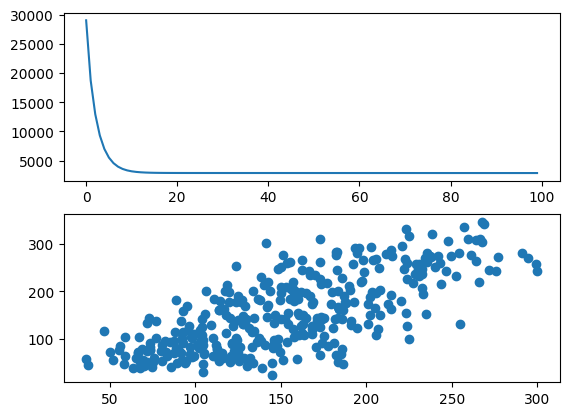

Parameter containing:
tensor([[  1.9413, -11.4535,  26.3020,  16.6372, -10.1897,  -2.1343,  -7.4969,
           8.3693,  22.0618,   2.6037, 153.7365]])
Minimum cost: 2890.02294921875


In [ ]:
cost_lst = list() #store the cost (mean squared error) at each iteration of the training loop. It helps in tracking the loss over time to visualize the learning process.
model = LinearRegression(x_train.shape[1]) #instantiates the LinearRegression model, passing the number of input features to the model
alpha = .1 #learning rate controls how large the steps are when updating the weights during gradient descent
for it in range(100):
  prediction = model(x_train) #The model takes the training data (x_train) and makes predictions.
  #calculate the mean squared error (MSE), which represents the cost (or loss) for this iteration. It measures how far off the predictions are from the actual target values (y_train).
  cost = mean_squared_error(y_train, prediction)
  cost_lst.append(cost)
  #performs a single step of gradient descent. It calculates the gradient of the cost function with respect to the model's weights and updates the weights based on the learning rate
  #with this we adjust the weights slightly in the direction that reduces the error, trying to make the model's predictions closer to the true values (y_train).
  gradient_descent_step(model, x_train, y_train, prediction, alpha)
fig, axs = plt.subplots(2)
axs[0].plot(list(range(it+1)), cost_lst) #shows how the cost decreases over time
axs[1].scatter(prediction, y_train) # scatter plot that compares the model's predictions with the actual values
plt.show()
print(model.weight)
print('Minimum cost: {}'.format(min(cost_lst)))

<font color="maroon">**Q5.** What conclusion if any can be drawn from the weight values? How does sex and BMI affect diabetes disease progression?

What are the estimated disease progression values for the below examples? [2 marks] </font>

| AGE | SEX | BMI | BP  | S1  | S2    | S3 | S4  | S5     | S6  |
|-----|-----|-----|-----|-----|-------|----|-----|--------|-----|
| 25  | F   | 18  | 79  | 130 | 64.8  | 61 | 2   | 4.1897 | 68  |
| 50  | M   | 28  | 103 | 229 | 162.2 | 60 | 4.5 | 6.107  | 124 |

In [ ]:


example_data = torch.tensor([
    [25, 2, 18, 79, 130, 64.8, 61, 2, 4.1897, 68],  # Female example
    [50, 1, 28, 103, 229, 162.2, 60, 4.5, 6.107, 124]  # Male example
], dtype=torch.float32)


example_data_normalized = norm_set(example_data, mu, sigma)


example_data_with_bias = torch.cat([example_data_normalized, torch.ones(example_data_normalized.shape[0], 1)], dim=1)


predicted_progression_examples = model(example_data_with_bias)

print("Predicted disease progression values for the examples:")
values_per_line = 9
for i in range(0, len(predicted_progression_examples), values_per_line):
    print(predicted_progression_examples[i:i + values_per_line])





print()
print()
#test_cost = mean_squared_error(predicted_progression, y_test)
#print("Test Mean Squared Error:", test_cost.item())


sex_weight = model.weight[0, 1].item()  # Weight for Sex (column index 1)
bmi_weight = model.weight[0, 2].item()  # Weight for BMI (column index 2)

print("Learned Model Weights:", model.weight)
print(f"Weight for Sex: {sex_weight}")
print(f"Weight for BMI: {bmi_weight}")


if sex_weight > 0:
    print("Being female (Sex = 2) increases the progression of diabetes compared to being male (Sex = 1).")
else:
    print("Being female (Sex = 2) reduces the progression of diabetes compared to being male (Sex = 1).")

if bmi_weight > 0:
    print("Higher BMI increases the progression of diabetes.")
else:
    print("Higher BMI decreases the progression of diabetes.")


Predicted disease progression values for the examples:
tensor([[ 43.5994],
        [232.6103]])


Learned Model Weights: Parameter containing:
tensor([[  1.9413, -11.4535,  26.3020,  16.6372, -10.1897,  -2.1343,  -7.4969,
           8.3693,  22.0618,   2.6037, 153.7365]])
Weight for Sex: -11.453505516052246
Weight for BMI: 26.3019962310791
Being female (Sex = 2) reduces the progression of diabetes compared to being male (Sex = 1).
Higher BMI increases the progression of diabetes.


Now estimate the error on the test set. Is the error on the test set comparable to that of the train set? What can be said about the fit of the model? When does a model over/under fits?


In [ ]:
#predictions for test and train
train_predictions = model(x_train)
test_predictions = model(x_test)

#mse for train
train_mse = mean_squared_error(train_predictions, y_train)
print("Mean Squared Error on the training set:", train_mse.item())

#mse for test
test_mse = mean_squared_error(test_predictions, y_test)
print("Mean Squared Error on the test set:", test_mse.item())
print()
print("Interpretation of MSE on Sets")
if test_mse.item() > train_mse.item():
    print("MSE Test Set > MSE Train Set => may indicate overfitting")
elif test_mse.item() < train_mse.item():
    print("MSE Train Set > MSE Test Set => may indicate underfitting")
else:
    print("MSE Train Set = MSE Test Set => indicates good fit")



Mean Squared Error on the training set: 2889.944091796875
Mean Squared Error on the test set: 2886.149169921875

Interpretation of MSE on Sets
MSE Train Set > MSE Test Set => may indicate underfitting


<font color="maroon">**Q6.** Try the code with several learning rates that differ by orders of magnitude, and record the training and test set errors. Describe the theory of how changing the learning rate affects learning. What do you observe in the training error? How about the error on the test set? [3 marks]</font>

In [ ]:
### your code here

learning_rates = [0.001, 0.01, 0.1, 1, 10]
results = []

for lr in learning_rates:

    model = LinearRegression(x_train.shape[1])
    cost_lst = []


    for it in range(100):
        prediction = model(x_train)
        cost = mean_squared_error(prediction, y_train)
        cost_lst.append(cost.item())
        gradient_descent_step(model, x_train, y_train, prediction, lr)

    final_train_mse = cost_lst[-1]

    test_predictions = model(x_test)
    test_mse = mean_squared_error(test_predictions, y_test).item()
    results.append({
        'Learning Rate': lr,
        'Final Training MSE': final_train_mse,
        'Test MSE': test_mse
    })

    print(f"Learning Rate: {lr}")
    print(f"Final Training MSE: {final_train_mse}")
    print(f"Test MSE: {test_mse}")
    print("----------")


results_df = pd.DataFrame(results)
print(results_df)


Learning Rate: 0.001
Final Training MSE: 19769.701171875
Test MSE: 18346.244140625
----------
Learning Rate: 0.01
Final Training MSE: 3351.271240234375
Test MSE: 3425.44384765625
----------
Learning Rate: 0.1
Final Training MSE: 2890.02294921875
Test MSE: 2886.149169921875
----------
Learning Rate: 1
Final Training MSE: nan
Test MSE: nan
----------
Learning Rate: 10
Final Training MSE: nan
Test MSE: nan
----------
   Learning Rate  Final Training MSE      Test MSE
0          0.001        19769.701172  18346.244141
1          0.010         3351.271240   3425.443848
2          0.100         2890.022949   2886.149170
3          1.000                 NaN           NaN
4         10.000                 NaN           NaN


# 1.2 Regularized Linear Regression
In this exercise, we will be trying to create a model that fits data that is clearly not linear. We will be attempting to fit the data points seen in the graph below:

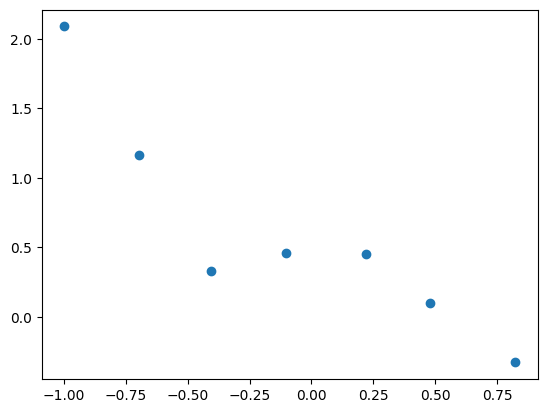

x shape: torch.Size([7])
y shape: torch.Size([7, 1])


In [ ]:
x = torch.tensor([-0.99768, -0.69574, -0.40373, -0.10236, 0.22024, 0.47742, 0.82229])
y = torch.tensor([2.0885, 1.1646, 0.3287, 0.46013, 0.44808, 0.10013, -0.32952]).reshape(-1, 1)
plt.scatter(x, y)
plt.show()

print(f"x shape: {x.shape}")
print(f"y shape: {y.shape}")

In order to fit this data we will create a new hypothesis function, which uses a fifth-order polynomial:

$
 h_{\theta}(x) = \theta_{0} x_{0} + \theta_{1} x_{1} + \theta_{2} x_{1} ^2 + \theta_{3} x_{1} ^3 + \theta_{4} x_{1} ^4 + \theta_{5} x_{1} ^5
$

As we are fitting a small number of points with a high order model, there is a danger of overfitting.  \\

To attempt to avoid this we will use regularization. Our cost function becomes:

$
 J(\theta) = \frac{1}{2m}  \left[ \sum_{i=1}^m ( h_{\theta}(x^{(i)}) - y^{(i)})^2 + \lambda    \sum_{j=1}^n \theta_{j}^2 \right]
$

Adjust variable `x` to include the different powers of $x_{1}$ as described by the hypothesis function. e.g $x_{1}, x_{1} ^2, ..., x_{1}^5$. Hint: Remember to include $x_0$ which is our bias term.

In [ ]:
x3 = torch.cat([x.view(-1, 1)**i for i in range(6)], dim=1)


print(f"x3 shape: {x3.shape}")
print(f"y shape: {y.shape}")


x3 shape: torch.Size([7, 6])
y shape: torch.Size([7, 1])


**Q7.** Update the cost and gradient descent methods to use the regularised cost, as shown above. [4 marks]

Note that the punishment for having more terms is not applied to the bias. This means that we use a different update technique for the partial derivative of $\theta_{0}$, and add the regularization to all of the others:



$
 \theta_{j} =  \theta_{j} - \alpha \frac{1}{m} \sum_{i=1}^m ( h_{\theta}(x^{(i)}) - y^{(i)})x^{(i)}_{j} , j=0
$



$
 \theta_{j} =  \theta_{j} (1 - \alpha \frac{\lambda}{m}) -
 \alpha \frac{1}{m} \sum_{i=1}^m ( h_{\theta}(x^{(i)}) - y^{(i)})x^{(i)}_{j} , j>0
$

In [ ]:


def mean_squared_error(y_true: torch.Tensor, y_pred: torch.Tensor, lam: float, theta: torch.Tensor) -> torch.Tensor:
    mse_loss = ((y_pred - y_true) ** 2).mean()

    regularization = lam * torch.sum(theta[:, 1:] ** 2) / (2 * y_true.size(0))

    return mse_loss + regularization


def gradient_descent_step(model: nn.Module, X: torch.Tensor, y: torch.Tensor, y_pred: torch.Tensor, lr: float, lam: float) -> None:
    weight = model.weight.detach().clone()
    N = X.shape[0]

    error = y_pred - y
    gradient_theta0 = (2 / N) * torch.sum(error)
    gradient_theta_j = (2 / N) * torch.matmul(error.T, X[:, 1:]) + (2 * lam / N) * weight[:, 1:]

    weight[:, 0] -= lr * gradient_theta0
    weight[:, 1:] -= lr * gradient_theta_j
    model.weight = nn.Parameter(weight, requires_grad=False)


<font color="maroon"> **Q8.** First of all, find the best value of alpha to use in order to optimize best.
Next, experiment with different values of $\lambda$ and see how this affects the shape of the hypothesis. [3 marks]</font>

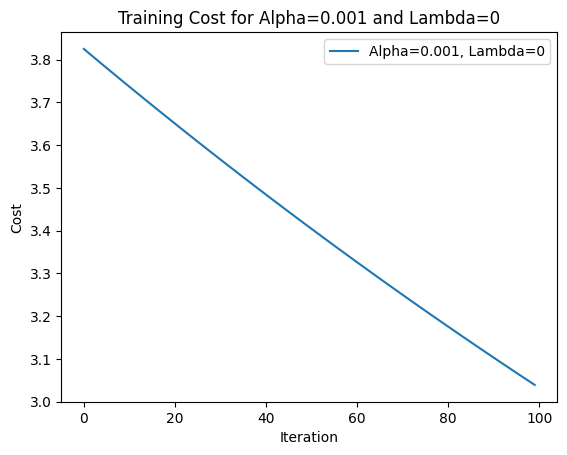

Alpha: 0.001, Lambda: 0, Final Cost: 3.0390677452087402


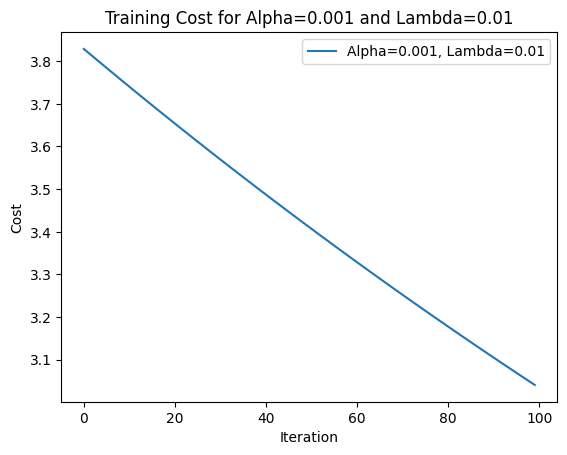

Alpha: 0.001, Lambda: 0.01, Final Cost: 3.041024923324585


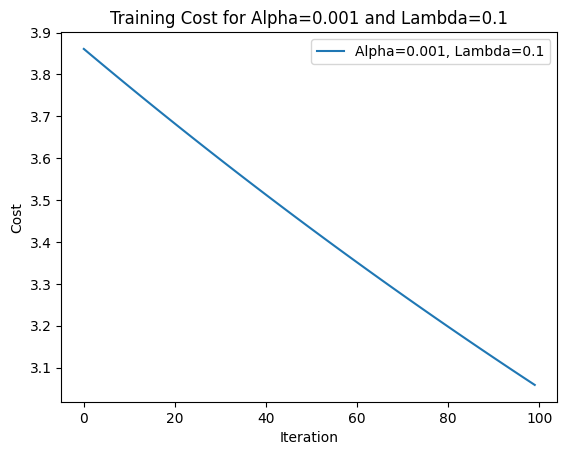

Alpha: 0.001, Lambda: 0.1, Final Cost: 3.0585100650787354


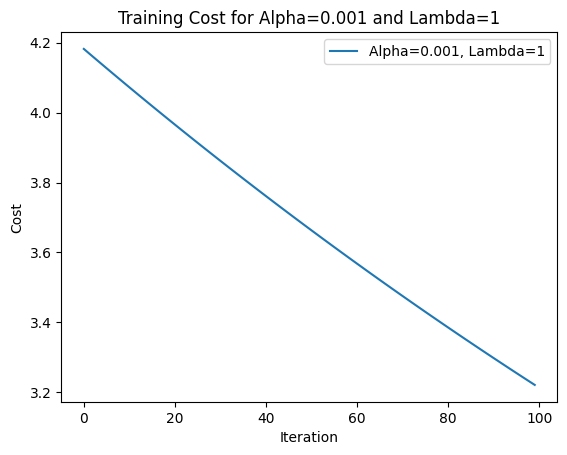

Alpha: 0.001, Lambda: 1, Final Cost: 3.2206101417541504


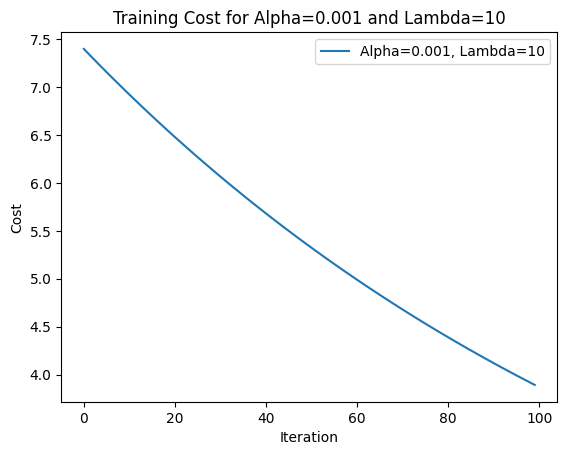

Alpha: 0.001, Lambda: 10, Final Cost: 3.8926467895507812


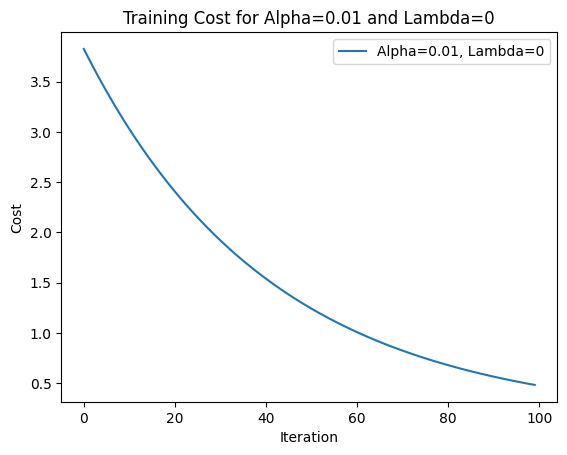

Alpha: 0.01, Lambda: 0, Final Cost: 0.4828914999961853


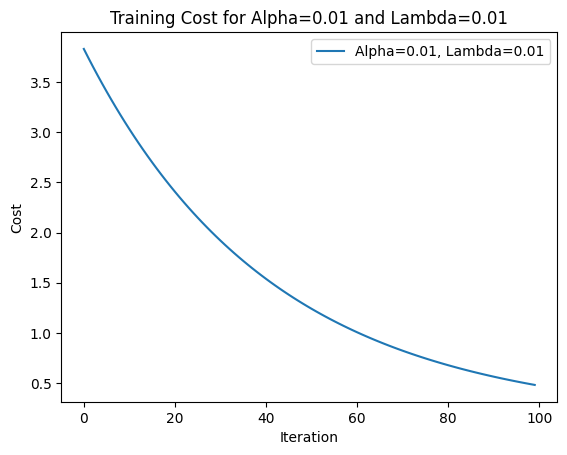

Alpha: 0.01, Lambda: 0.01, Final Cost: 0.48259782791137695


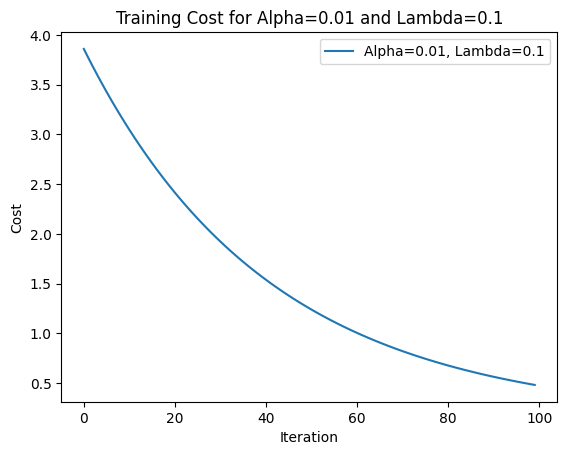

Alpha: 0.01, Lambda: 0.1, Final Cost: 0.47975072264671326


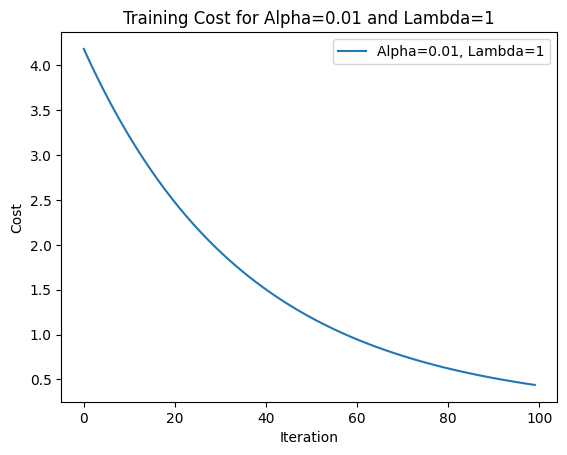

Alpha: 0.01, Lambda: 1, Final Cost: 0.4390711188316345


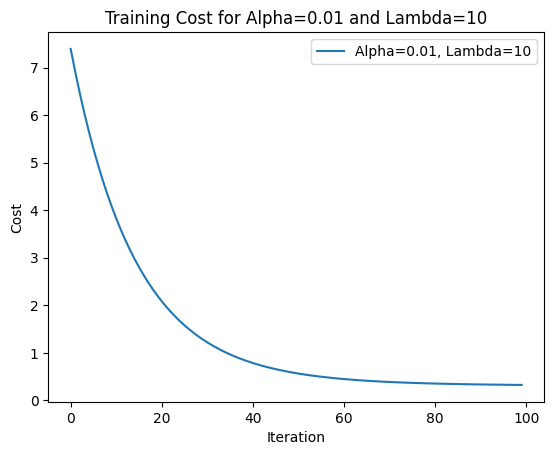

Alpha: 0.01, Lambda: 10, Final Cost: 0.3238323926925659


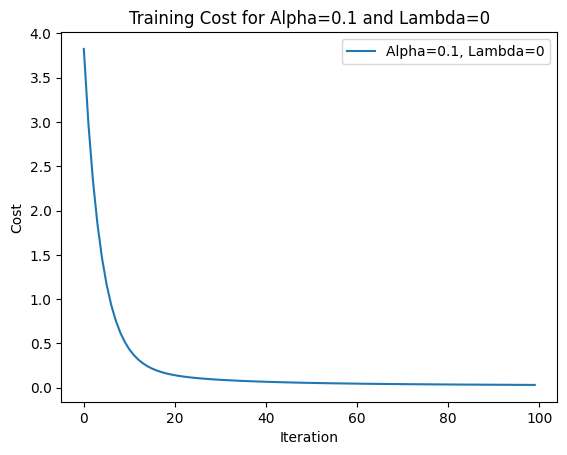

Alpha: 0.1, Lambda: 0, Final Cost: 0.031656358391046524


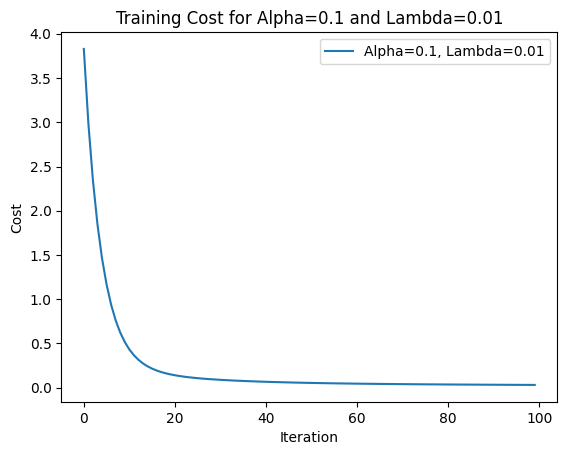

Alpha: 0.1, Lambda: 0.01, Final Cost: 0.03185524046421051


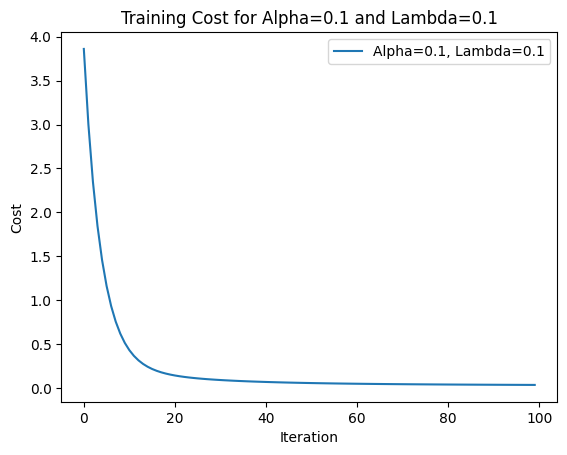

Alpha: 0.1, Lambda: 0.1, Final Cost: 0.03384290635585785


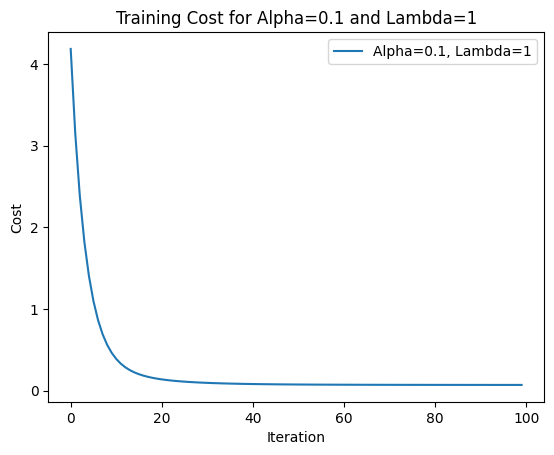

Alpha: 0.1, Lambda: 1, Final Cost: 0.07071711122989655


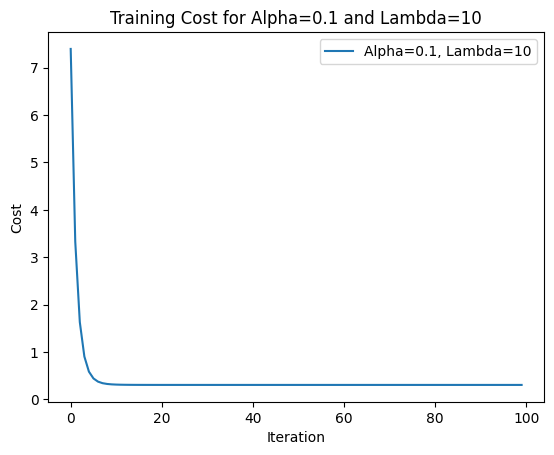

Alpha: 0.1, Lambda: 10, Final Cost: 0.3052743971347809
Best alpha: 0.1
Best lambda: 0
Minimum cost: 0.031656358391046524
Best model weights: tensor([[ 0.3157, -0.6704,  0.1234, -0.4161,  0.5033, -0.0618]])


--- Exploring different lambda values with best alpha ---


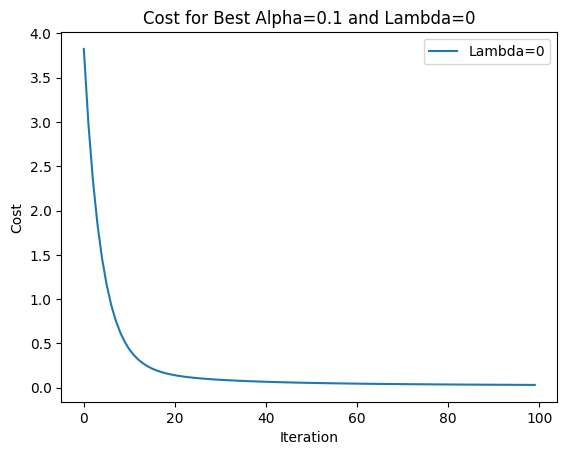

Best Alpha: 0.1, Lambda: 0, Final Cost: 0.031656358391046524


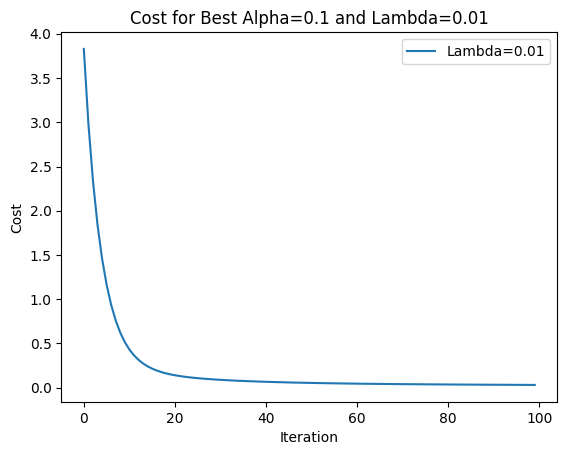

Best Alpha: 0.1, Lambda: 0.01, Final Cost: 0.03185524046421051


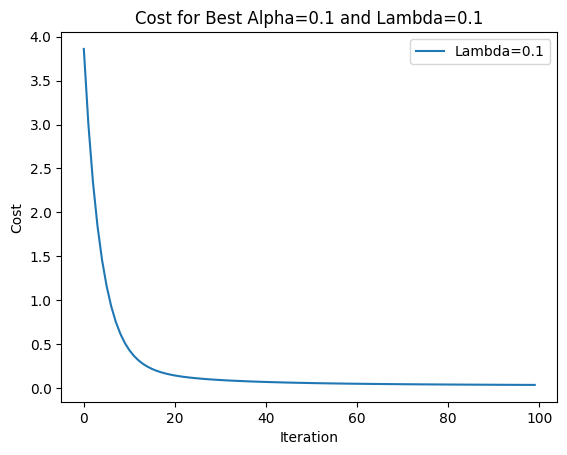

Best Alpha: 0.1, Lambda: 0.1, Final Cost: 0.03384290635585785


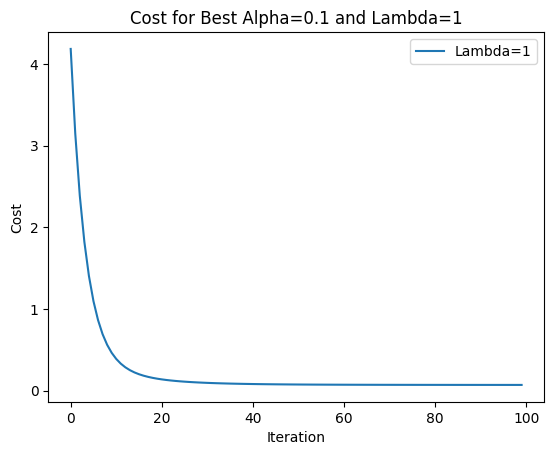

Best Alpha: 0.1, Lambda: 1, Final Cost: 0.07071711122989655


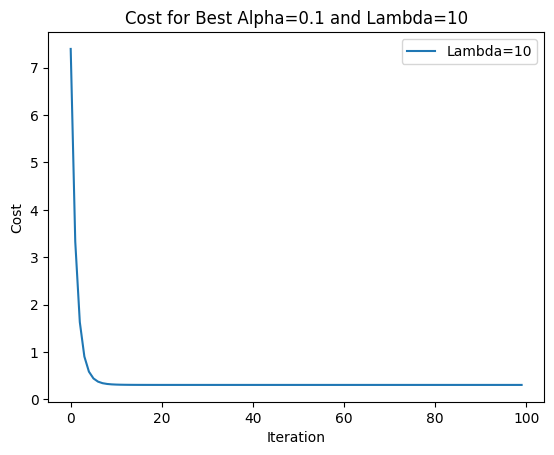

Best Alpha: 0.1, Lambda: 10, Final Cost: 0.3052743971347809


In [ ]:



alphas = [0.001, 0.01, 0.1]
lambdas = [0, 0.01, 0.1, 1, 10]

best_alpha = None
best_lambda = None
min_cost = float('inf')
best_model_weights = None


for alpha in alphas:
    for lam in lambdas:

        model = LinearRegression(x3.shape[1])
        cost_lst = []


        for it in range(100):
            prediction = model(x3)
            if prediction.shape != y.shape:
                raise ValueError(f"Shape mismatch: prediction shape {prediction.shape}, y shape {y.shape}")
            cost = mean_squared_error(y, prediction, lam, model.weight)
            cost_lst.append(cost)
            gradient_descent_step(model, x3, y, prediction, alpha, lam)


        final_cost = cost_lst[-1].item()


        if final_cost < min_cost:
            min_cost = final_cost
            best_alpha = alpha
            best_lambda = lam
            best_model_weights = model.weight.data.clone()


        plt.plot(list(range(it+1)), cost_lst, label=f'Alpha={alpha}, Lambda={lam}')
        plt.xlabel('Iteration')
        plt.ylabel('Cost')
        plt.legend()
        plt.title(f'Training Cost for Alpha={alpha} and Lambda={lam}')
        plt.show()


        print(f"Alpha: {alpha}, Lambda: {lam}, Final Cost: {final_cost}")


print(f"Best alpha: {best_alpha}")
print(f"Best lambda: {best_lambda}")
print(f"Minimum cost: {min_cost}")
print(f"Best model weights: {best_model_weights}")
print()

print("\n--- Exploring different lambda values with best alpha ---")
for lam in lambdas:

    model = LinearRegression(x3.shape[1])
    cost_lst = []


    for it in range(100):
        prediction = model(x3)
        cost = mean_squared_error(y, prediction, lam, model.weight)
        cost_lst.append(cost)
        gradient_descent_step(model, x3, y, prediction, best_alpha, lam)


    plt.plot(list(range(it+1)), cost_lst, label=f'Lambda={lam}')
    plt.xlabel('Iteration')
    plt.ylabel('Cost')
    plt.legend()
    plt.title(f'Cost for Best Alpha={best_alpha} and Lambda={lam}')
    plt.show()


    final_cost = cost_lst[-1].item()
    print(f"Best Alpha: {best_alpha}, Lambda: {lam}, Final Cost: {final_cost}")


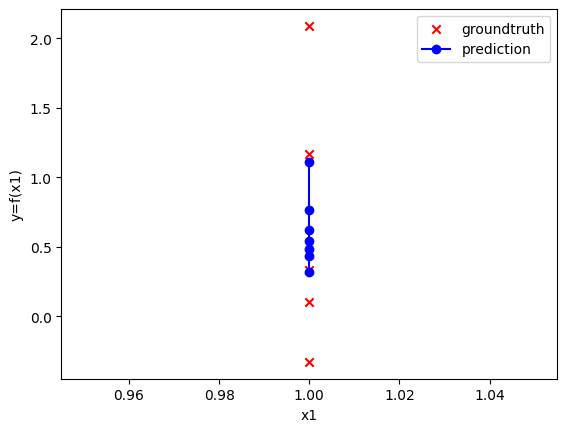

In [ ]:
plt.scatter(x3[:, 0], y, c='red', marker='x', label='groundtruth')
outputs = model(x3)
plt.plot(x3[:, 0], outputs, c='blue', marker='o', label='prediction')
plt.xlabel('x1')
plt.ylabel('y=f(x1)')
plt.legend()
plt.show()